<a href="https://colab.research.google.com/github/jxin11/RNN-fake-news-detection/blob/main/RNN_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [84]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Dropout, Bidirectional
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

# Load Dataset

In [7]:
!unzip /content/fake_news_dataset.zip

unzip:  cannot find or open /content/fake_news_dataset.zip, /content/fake_news_dataset.zip.zip or /content/fake_news_dataset.zip.ZIP.


In [18]:
fake_df = pd.read_csv("/content/Fake.csv")
real_df = pd.read_csv("/content/True.csv")

In [19]:
fake_df['class'] = 1 
real_df['class'] = 0
news_df = pd.concat([fake_df, real_df], ignore_index=True)
news_df

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [20]:
news_df.drop(['date', 'subject'], axis=1, inplace=True)

In [21]:
news_df['text'] = news_df['title'] + " " + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [22]:
news_df

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,0
44894,LexisNexis withdrew two products from Chinese ...,0
44895,Minsk cultural hub becomes haven from authorit...,0
44896,Vatican upbeat on possibility of Pope Francis ...,0


In [23]:
print("Total no. of news: ", news_df.shape[0])
print("Total no. of unique labels: ", Counter(news_df['class']))

Total no. of news:  44898
Total no. of unique labels:  Counter({1: 23481, 0: 21417})


# Train Test Split

In [68]:
X = news_df['text']
y = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

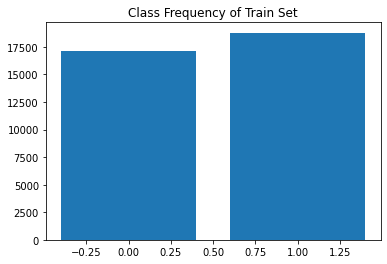


Train Set
0: 17133 (47.7%)
1: 18785 (52.3%)


In [69]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(y_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

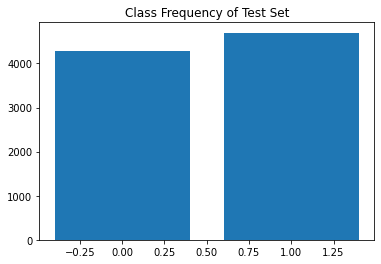


Test Set
0: 4284 (47.71%)
1: 4696 (52.29%)


In [70]:
# Plot Class Freqeuncy of Test Set
c_test = OrderedDict(sorted(Counter(y_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Data Cleaning (X_train and X_test)

In [71]:
X_train[0]

' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this 

In [72]:
def cleanText(txt):
  txt = txt.strip().lower()
  txt = txt.replace('\n',' ').replace('\r',' ').replace('\t',' ').replace('\xa0',' ').replace('\x0c',' ').replace('.', '. ').replace('\'s',' ')
  txt = re.sub('https?://\S+|www\.\S+', '', txt)
  txt = re.sub('\\W', ' ', txt)
  txt = re.sub(' +', ' ', txt)
  txt = re.sub('^ ', '', txt)
  txt = re.sub(' $', '', txt)
  return txt

In [73]:
cleanText(X_train[0])

'donald trump sends out embarrassing new year s eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted 2018 will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year 2018 will be a great year for america donald j trump realdonaldtrump december 31 2017trump s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable petty infantile gibberi

In [74]:
X_train = X_train.apply(lambda x: cleanText(x))
X_test = X_test.apply(lambda x: cleanText(x))

In [75]:
X_train[0]

'donald trump sends out embarrassing new year s eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted 2018 will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year 2018 will be a great year for america donald j trump realdonaldtrump december 31 2017trump s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable petty infantile gibberi

In [76]:
num_words = 10000  # only the num_words most frequent words are kept. Any less frequent word will appear as oov_char value in the sequence data
max_len = 100

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [77]:
X_train = sequence.pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')  # pre / post
X_test = sequence.pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

#Model Construction

In [85]:
tf.random.set_seed(1234)

In [87]:
model = Sequential()

model.add(Embedding(num_words, 128))   # 32 - neurons
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True))) # output all the hidden states of each time steps
model.add(Bidirectional(LSTM(16, activation='relu')))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary classification

In [88]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc'])

In [89]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1)

def scheduler(epoch, learning_rate):
  if epoch % 2 != 0 or epoch == 0:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.94)

lr_scheduler = LearningRateScheduler(scheduler)

In [90]:
callbacks_list = [early, reduce_lr, lr_scheduler]

# Model Training

In [91]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), shuffle=True,
                    callbacks=callbacks_list)

Epoch 1/10
562/562 [==============================] - 375s 659ms/step - loss: 6616.7935 - acc: 0.8771 - val_loss: 0.3252 - val_acc: 0.9118 - lr: 1.0000e-04
Epoch 2/10
562/562 [==============================] - 368s 655ms/step - loss: 0.1750 - acc: 0.9658 - val_loss: 0.1119 - val_acc: 0.9731 - lr: 1.0000e-04
Epoch 3/10
562/562 [==============================] - 370s 658ms/step - loss: 0.0884 - acc: 0.9801 - val_loss: 0.1422 - val_acc: 0.9736 - lr: 3.9063e-05
Epoch 4/10
562/562 [==============================] - 369s 657ms/step - loss: 0.0745 - acc: 0.9820 - val_loss: 0.1037 - val_acc: 0.9741 - lr: 3.9063e-05
Epoch 5/10
562/562 [==============================] - 369s 656ms/step - loss: 0.0661 - acc: 0.9843 - val_loss: 0.1054 - val_acc: 0.9743 - lr: 1.5259e-05
Epoch 6/10
562/562 [==============================] - 370s 658ms/step - loss: 0.0625 - acc: 0.9847 - val_loss: 0.1056 - val_acc: 0.9748 - lr: 1.5259e-05
Epoch 7/10
562/562 [==============================] - 374s 665ms/step - loss: 0

# Model Evaluation

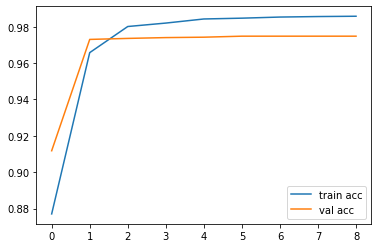

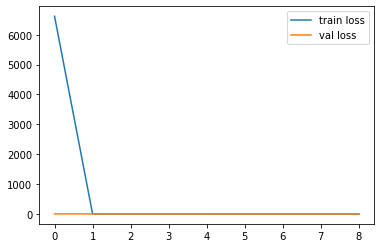

In [92]:
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [93]:
pred = [1 if i >= 0.5 else 0 for i in model.predict(X_test)]

In [94]:
accuracy_score(y_test, pred)

0.974053452115813